In [11]:
%config IPCompleter.greedy=True

In [12]:
import sys
import os
import pandas as pd
sys.path.append("..") # relative path to module toolkit

In [13]:
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# setup
batch_size = 1
val_dir = "./val_segmented/Beetles/"
val_images = 3113
datasetDir = "images_genus/"
saved_model = '../resNet50_pretrained/restnet50pretrained.h5'
results_file = "results_noBackground.csv"

In [15]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) 

In [16]:
model = load_model(saved_model)

In [17]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    seed=1)

Found 3113 images belonging to 44 classes.


In [18]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

3113/3113 [==============================] - 79s 25ms/step


In [19]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [20]:
#print(classification_report(val_generator.classes, y_pred, target_names=labels))
print(classification_report(val_generator.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

  Lobrathium       0.59      0.86      0.70        22
    Achenium       0.73      1.00      0.84         8
 Acylophorus       0.86      0.95      0.90        20
     Astenus       1.00      0.96      0.98       115
     Atrecus       0.70      1.00      0.82        14
     Bisnius       0.95      0.81      0.87       176
      Cafius       1.00      0.95      0.97        58
  Creophilus       0.70      1.00      0.82         7
Dinothenarus       0.67      0.75      0.71         8
        Emus       1.00      1.00      1.00         4
 Erichsonius       0.97      0.92      0.94        36
   Euryporus       1.00      1.00      1.00         8
     Gabrius       0.95      0.88      0.91       114
  Gabronthus       1.00      1.00      1.00         5
 Gauropterus       1.00      0.79      0.88        14
  Gyrohypnus       0.91      0.84      0.88        51
 Heterothops       1.00      0.92      0.96        60
  Lathrobium       1.00    

Normalized confusion matrix
[[ 0.86363636  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          1.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.95       ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.9875      0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.92156863]]


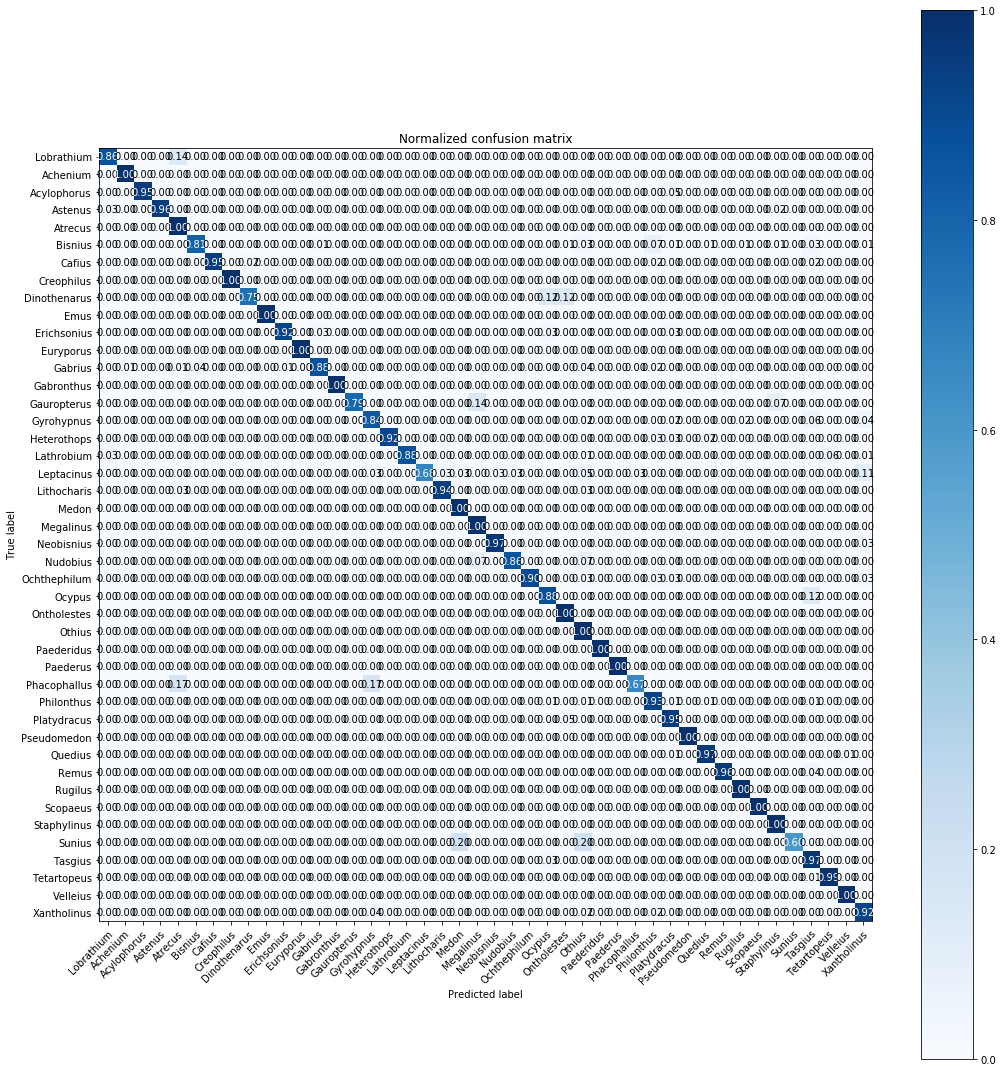

In [23]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [15, 15]
plot_confusion_matrix(y_true, y_pred, np.array(labels), normalize=True)

In [24]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [25]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)